<a href="https://colab.research.google.com/github/mohammad2682/FVS-SVM-RKHS/blob/main/SVM_RKHS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.display import clear_output

In [2]:
!git clone https://github.com/mohammad2682/FVS-SVM-RKHS

Cloning into 'FVS-SVM-RKHS'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 113 (delta 40), reused 41 (delta 17), pack-reused 0
Receiving objects: 100% (113/113), 923.77 KiB | 272.00 KiB/s, done.
Resolving deltas: 100% (40/40), done.


In [3]:
def sigma(df):
  N = df.shape[0]
  sigma = []
  for i in range(N):
    for j in range(i+1, N):
      x_i = df.iloc[[i], :-1]
      x_j = df.iloc[[j], :-1]
      sigma.append(np.linalg.norm(x_i.values - x_j.values))
  return 0.1 * np.max(sigma)

In [79]:
def K(FV1, FV2, sig):
  dist = np.linalg.norm(FV1-FV2)
  return np.exp(-1*np.square(dist)/(2*sig))

In [91]:
def give_KSS(S, sig):
  KSS = []
  for vec1 in S:
    for vec2 in S:
      k = K(np.array(vec1), np.array(vec2), sig = sig)
      KSS.append(k)

  return np.array(KSS).reshape((len(S), len(S)))

In [92]:
def give_KSx(S, x, sig):
  KSx = []
  for s in S:
    kx = K(np.array(s), x, sig = sig)
    KSx.append(kx)
  return np.array(KSx).reshape((len(S), 1))

In [93]:
def minor_major(df):
  cls = df.iloc[:,-1].unique()
  cls0 = df[df.iloc[:,-1]==cls[0]].shape[0]
  cls1 = df[df.iloc[:,-1]==cls[1]].shape[0]
  minor = cls[0]
  major = cls[1]
  if cls0>cls1:
    minor = cls[1]
    major = cls[0]
  return minor, major

In [94]:
def S_creator(df, FV1, SN):
  df_new = df.drop(index = FV1.index)
  FV1 = FV1.iloc[0].values
  tau = min(0.001, 1/df.shape[0]) #minimum of 0.001, 1/N
  S = [list(FV1)]
  cnt = 1
  for vec in df_new.iloc[:, :-1].values:
    KSx = give_KSx(S, vec, sig = sig)
    KSS = give_KSS(S, sig = sig)
    LF = abs(1-(np.dot(np.dot(np.transpose(KSx), np.linalg.inv(KSS)), KSx)))
    if LF > tau:
      S.append(list(vec))
      cnt += 1
      
      clear_output(wait=True)
      print(str((cnt/SN)*100)+"%")
      
      if cnt == SN:
        break
  return S

In [95]:
def give_landa(df, minor_cls, major_cls):
  minor = df[df["Class"] == minor_cls]
  major = df[df["Class"] == major_cls]
  landa = []
  for col in df.columns[:-1]:
    mean_minor = minor[col].mean()
    mean_major = major[col].mean()
    var_minor = minor[col].var()
    var_major = major[col].var()
    landa_i = np.square(mean_minor - mean_major)/(var_minor - var_major)
    landa.append(landa_i)
  return landa

In [96]:
df = pd.read_csv("FVS-SVM-RKHS/datasets/shuttle-6_vs_2-3.csv")
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,Class
0,70,57,82,0,-42,-4,12,126,114,negative
1,37,-38,106,-104,30,-17,69,75,6,negative
2,52,-30,79,0,0,0,27,79,52,negative
3,78,-33,88,-4,8,0,10,81,70,negative
4,68,-27,107,0,60,-5,38,47,10,negative


In [97]:
#df_test1 = df.iloc[:7, :]
#df_test2 = df.iloc[-25:, :]
#df_test = pd.concat([df_test1, df_test2]).reset_index(drop=True)
#df_test = df_test[["preg", "plas", "skin", "class"]]

# if you want to train with whole data, uncomment below line
df_train = df.copy()

In [98]:
sig = sigma(df = df_train)
minor_cls, major_cls = minor_major(df_train)

In [99]:
print(sig)
print(minor_cls, major_cls)

316.8348939116397
positive negative


In [100]:
if "Class" in df_train:
  df_train.rename(columns={"Class": "class"}, inplace= True)
df_train["class"].value_counts()

negative    220
positive     10
Name: class, dtype: int64

In [101]:
SN = 20
minor_df = df_train[df_train["class"]==minor_cls]
S_T = []
FV_T = pd.DataFrame()
for i in range(minor_df.shape[0]):
  FV1 = minor_df.iloc[[i], :-1]
  S_T.append(S_creator(df_train, FV1, SN))
  FV_T = pd.concat([FV_T, FV1])

100.0%


In [103]:
landa_max = -1000
tot = np.shape(S_T)[-1]
for i, S in enumerate(S_T):

  FV1 = FV_T.iloc[[i]]
  df_new = df_train.drop(index = FV1.index, axis = 0 )
  cls = []
  flag = 0
  #sort Data
  for vector in df_new.values:
    vec = np.array(list(vector[:-1]))
    cls.append(vector[-1])
    KSx = give_KSx(S, vec, sig = sig)
    KSS = give_KSS(S, sig = sig)
    DSS = np.diag(np.diag(np.sqrt(KSS)))
    beta = np.dot(np.transpose(KSx), np.linalg.inv(KSS))
    #beta = np.dot(np.dot(np.transpose(KSx), np.linalg.inv(KSS)), DSS)
    if flag == 0:
      B = beta
      flag = -1
      continue
    B = np.concatenate((B, beta))

  B_df = pd.DataFrame(B)
  B_df["Class"] = cls

  '''
  a = B_df[B_df["Class"] == minor_cls]
  Npos = a.shape[0] * -1
  a = pd.concat([a,a])
  a = pd.concat([a, B_df[B_df["Class"]==major_cls].iloc[:Npos,:]])
  '''

  landa = give_landa(B_df, minor_cls, major_cls)

  clear_output(wait=True)
  print(str((i/tot)*100)+"%")

  landa_t = np.sum(landa)/len(S)
  if landa_t > landa_max:
    #print(landa_t)
    landa_max = landa_t
    best_S = S

100.0%


## Second Section

In [104]:
for m in range(np.shape(best_S)[0]):
  omeg_m = []
  for n in range(np.shape(best_S)[0]):
    omeg_mn = np.sum(np.dot(B_df.iloc[:, m], B_df.iloc[:, n]))
    omeg_m.insert(n, omeg_mn)
  if m == 0:
    omeg = omeg_m
    continue
  omeg = np.concatenate((omeg, omeg_m))
omeg = np.array(omeg).reshape((np.shape(best_S)[0], np.shape(best_S)[0]))

In [105]:
B_df.iloc[:, 0]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
224    0.0
225    0.0
226    0.0
227    0.0
228    0.0
Name: 0, Length: 229, dtype: float64

In [45]:
H = []
for m in range(np.shape(best_S)[0]):
  H_j = np.sum(B_df.iloc[m, :-1])
  H_m = np.sum(np.dot(B_df.iloc[:,m], (1-H_j)))
  H.insert(m, H_m)

In [46]:
tau = H.copy()

In [47]:
C = []
for m in range(np.shape(best_S)[0]):
  c_val = 1 - np.sum(B_df.iloc[m, :-1])
  C.insert(m, c_val)
C = np.sum(np.square(C))

In [48]:
B_df["y_i"] = B_df['Class']
B_df["y_i"].replace({minor_cls: -1, major_cls: 1}, inplace=True)

In [49]:
P = []
for m in range(np.shape(best_S)[0]):
  P_m = np.sum(np.dot(B_df.iloc[:, m], B_df["y_i"]))
  P.insert(m, P_m)

In [50]:
L = np.sum(np.dot((1 - B_df.iloc[:, :-2].sum(axis=1)), B_df.iloc[:, -1]))

In [51]:
H = np.array(H).reshape((-1, 1))
tau = np.array(tau).reshape((-1, 1))
P = np.array(P).reshape((-1, 1))

In [52]:
row_a = np.concatenate((omeg, H), axis = 1)
row_b = np.append(tau.transpose(), C)
row_b = row_b.reshape((1,row_b.shape[0]))
A = np.concatenate((row_a, row_b), axis = 0)

In [53]:
Z = np.append(P, L).reshape((-1, 1))

In [55]:
omeg

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  4.17662973e+01,  1.35719632e-16,
        -2.61578888e-06, -4.28173524e-06,  1.60120967e-10,
        -7.02810715e-09, -7.04854489e-02,  3.94968755e-06,
         4.46912717e-06,  2.81649801e-06, -2.30699960e-07,
        -2.31715761e-06, -3.27908919e-11,  4.21920442e-12,
        -1.80248832e-12,  5.20347260e-10, -2.28144686e-08,
        -3.16989508e-09, -4.15355753e+01],
       [ 0.00000000e+00,  1.35719632e-16,  1.00000000e+00,
         7.20189539e-10,  9.41617519e-11,  7.78233191e-10,
         8.55798800e-09, -1.97199930e-13, -4.39717239e-10,
        -8.48380114e-10, -1.1

In [56]:
output = np.linalg.solve(A, Z)
y_hat = output[:SN]
b = output[-1]

LinAlgError: ignored

In [ ]:
print("y_hat: ", y_hat)
print("b: ", b)

y_hat:  [[-2.72769711e+169]
 [-2.37280179e+002]
 [ 3.66931676e+000]
 [-4.89242237e+002]
 [-1.19533788e+004]
 [ 1.66110788e+000]
 [-1.66157334e+001]
 [ 1.00247599e+001]
 [ 1.71747592e+004]
 [ 3.62365702e+002]
 [ 5.19756567e+003]
 [-2.19417406e+001]
 [-1.09252391e+004]
 [-3.25512768e+000]
 [ 6.30263306e+000]
 [-6.68379314e+000]
 [ 4.53153976e+000]
 [ 3.70688889e+002]
 [ 1.97256004e+001]
 [ 2.36825540e+002]]
b:  [0.99415994]


## g(xi)

In [ ]:
B_df["g(xi)"] = np.nan
for i in range(B_df.shape[0]):
  B_df.loc[i, "g(xi)"] = np.dot(B_df.iloc[i, 0:-3], (y_hat-b)) + b

negative  g(xi) mean value:  -0.9834676093321832
positive  g(xi) mean value:  0.9941599393723837


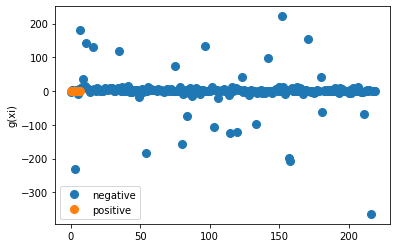

In [ ]:
B_df.drop(index = 208, inplace=True)

groups = B_df.groupby('Class')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(np.arange(0, group.shape[0]), group["g(xi)"], marker='o', linestyle='', ms=8, label=name)
    print(name, " g(xi) mean value: ", np.mean(group["g(xi)"]))
ax.legend()
plt.ylabel("g(xi)")

plt.show()

In [ ]:
# change threshold to change the model's performance:
classifier_thresh = 0

B_df["y_pred"] = major_cls
for i, g_xi in enumerate(B_df["g(xi)"]):
  if g_xi > classifier_thresh:
    B_df.loc[i, "y_pred"] = minor_cls

## Model Evaluation

* Confusion Matrix

In [ ]:
cls_types= np.array([major_cls, minor_cls])

In [ ]:
Y_pred = B_df["y_pred"].values
Y_true = B_df["Class"].values

Text(0.5, 89.87999999999997, 'Predicted')

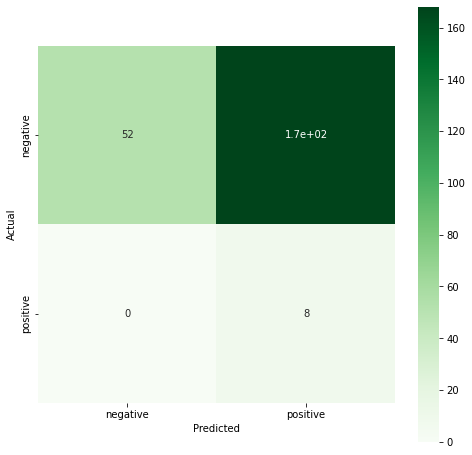

In [ ]:
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=cls_types, yticklabels=cls_types)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

In [ ]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[0][1]
FP = cm[1][0]

TPR = TP / (TP+FN)
TNR = TN / (TN+FP)
precision = TP / (TP+FP)

In [ ]:
G_mean = np.sqrt(TPR*TNR)
F_measure = (2*precision*TPR)/(precision+TPR)

In [ ]:
print("G-mean for threshold of ", classifier_thresh, " is: ", G_mean)
print("F-measure for threshold of ", classifier_thresh, " is: ", F_measure)

G-mean for threshold of  0  is:  0.21320071635561044
F-measure for threshold of  0  is:  0.08695652173913045


In [ ]:
acc = (TP+TN) / (TP+TN+FN+FP)
print(acc)

0.2631578947368421


In [ ]:
print(precision)

1.0
